# Training & Prediction fallow active agricultural areas
The goal of the script is to make use of sklearns algorithms for Random Forest and Support Vector Machine classifiers to train and predict fallow and active agricultural areas across Europe

Steps
- Import ROI 
- Load Sampling Data containing STM's and other info
- train-test splitting
- model training
- prediction
- accuracy assesment
- Output visualization

In [1]:
from osgeo import ogr, osr, gdal
import geemap, ee
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import math
from scipy.stats import norm, gamma, f, chi2
from functools import partial
import concurrent.futures
import pickle
import logging
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import joblib
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
import folium
import sys
import os

In [2]:
#workPath = 'D:/OneDrive - Humboldt-Universitaet zu Berlin, CMS/uni/WS_23_24/Geopy/MAP_git'
#workPath = "/Users/rubenbutzer/Library/CloudStorage/OneDrive-Humboldt-UniversitaetzuBerlin,CMS/uni/WS_23_24/Geopy/MAP_git"
#workPath = r'\\141.20.141.12\SAN_BioGeo\_HiWi\Ruben\wildE'
workPath = 'E:/MAP_git'

In [3]:
sys.path.append(workPath)
from tools import *
from tools_schnesha import *
from tools_butzerru import *

In [4]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Einladen der Sampling Daten

- hier kann schon gewählt werden, welche Seasons eingeladen werden sollen.

- weiterhin kann mit max_subset_size stattdessen ein subset geladen werden für schnelleres Prozessieren. Dafür muss if True gesetzt sein. 

In [5]:
# Definiere eine Liste von Seasons, die du verwenden möchtest
desired_seasons = ['3-9']

# Konvertiere die gewünschten Jahreszeiten in einen lesbaren String
seasons_str = '_'.join(desired_seasons)

# Optional: Definiere die maximale Größe des zwischengespeicherten Subsets
#max_subset_size = 'all'
max_subset_size = 100000

# Definiere den Pfad zur LUCAS-Beispieldatei im CSV-Format
path = os.path.join(workPath, '01_Sampling', 'lucas_points', 'LUCAS_sample_Both_Classes_All.csv')

#sampling_data = pd.read_csv(path)


# Überprüfe, ob das Pickle bereits vorhanden ist
pickle_file_name = f"LUCAS_random_sample_{seasons_str}"
if max_subset_size != 'all':
    if max_subset_size > 1774881:
        print("Die gewünschte Sample-Größe ist größer als die verfügbaren Daten. Bitte 'all' bei desired_seasons eingeben.")
        desired_seasons = 'all'
    else:
        pickle_file_name += f"_{max_subset_size}"
pickle_file_name += ".pkl"
pickle_path = os.path.join(workPath, "02_Training", "train_pickle", pickle_file_name)

if os.path.exists(pickle_path):
    print(f"Loading data from pickle {pickle_path}...")
    # Lade das Pickle direkt, wenn vorhanden
    training_data = pd.read_pickle(pickle_path)

    # Entferne Duplikate und fehlende Werte aus den Trainingsdaten
    training_data = training_data.drop_duplicates().dropna()

    # Ersetze den Wert "agriculture" in der Spalte 'land_use_classes' durch "active"
    training_data['land_use_classes'] = training_data['land_use_classes'].replace('agriculture', 'active')
else:
    print("Pickle file not found. Generating training data...")
    # Lade die CSV-Datei als Pandas DataFrame
    sampling_data = pd.read_csv(path)

    # Initialisiere eine leere DataFrame, um die gefilterten Daten zu speichern
    training_data = pd.DataFrame()

    # Iteriere über jede Season und filtere die Daten entsprechend
    for season in desired_seasons:
        # Filtere die Daten für die aktuelle Season
        season_data = sampling_data[sampling_data['season'] == season]

        # Füge die gefilterten Daten zur DataFrame hinzu
        training_data = pd.concat([training_data, season_data], ignore_index=True)

    # Erzeuge ein zufälliges Subset der Trainingsdaten, wenn die maximale Größe nicht 'all' ist
    if max_subset_size != 'all' and len(training_data) > max_subset_size:
        subset_data = training_data.sample(n=max_subset_size, random_state=42)
    else:
        subset_data = training_data
    
    # Speichere das Subset als Pickle-Datei
    subset_data.to_pickle(pickle_path)

    # Verwende das zwischengespeicherte Subset als Trainingsdaten
    training_data = subset_data

    # Entferne Duplikate und fehlende Werte aus den Trainingsdaten
    training_data = training_data.drop_duplicates().dropna()

    # Ersetze den Wert "agriculture" in der Spalte 'land_use_classes' durch "active"
    training_data['land_use_classes'] = training_data['land_use_classes'].replace('agriculture', 'active')

# Zeige die gefilterten Trainingsdaten an
print("Training data:")
print(training_data)


Loading data from pickle E:/MAP_git\02_Training\train_pickle\LUCAS_random_sample_3-9_100000.pkl...
Training data:
          B_mean     B_p10     B_p25     B_p50     B_p75     B_p90  B_stdDev   
282238  0.050944  0.035950  0.042894  0.049796  0.061580  0.064302  0.011544  \
111169  0.033231  0.018845  0.027026  0.032897  0.040597  0.045960  0.008562   
278814  0.073652  0.071315  0.071315  0.073652  0.075990  0.075990  0.002338   
387586  0.051051  0.016287  0.030450  0.049947  0.081297  0.090730  0.035128   
352444  0.046974  0.031358  0.040556  0.045974  0.052230  0.068647  0.015688   
...          ...       ...       ...       ...       ...       ...       ...   
44120   0.114156  0.040322  0.045437  0.068716  0.090482  0.115975  0.170260   
347878  0.100478  0.083058  0.091940  0.101455  0.108963  0.115837  0.012925   
418998  0.102600  0.078740  0.095295  0.109017  0.113830  0.121173  0.027340   
88520   0.042691  0.014390  0.027837  0.042591  0.057180  0.085780  0.054023   
359451

#### Optional: Remove cover classes that are not wanted

In [6]:
training_data["lc1"].unique()

array(['B18', 'E20', 'B11', 'B13', 'B74', 'B16', 'B15', 'F00', 'B81',
       'B22', 'E10', 'B82', 'B33', 'E30', 'B51', 'B14', 'BX1', 'A22',
       'B54', 'F40', 'B21', 'B32', 'D10', 'B55', 'B31', 'C10', 'D20',
       'B52', 'B23', 'B19', 'B53', 'B76', 'B72', 'B75', 'B41', 'B12',
       'B35', 'B34', 'B73', 'B84', 'B43', 'B45', 'A11', 'A13', 'B44',
       'B71', 'B42', 'B36', 'A21', 'C21', 'B37', 'B77', 'G11', 'B83',
       'G21', 'B17', 'C20', 'C22', 'BX2', 'G20', 'C30', 'C31', 'C32',
       'C33', 'H21', 'G10', 'F10', 'F30', 'C23', 'F20', 'A30'],
      dtype=object)

- A : Artificial
- B : Crop
- C : Woodland
- D : Shrubland
- E : Grassland
- F : Bare Land
- G : Water
- H : Wetland


removing all classes apart from Cropland, Grassland, Shrubland, Bare Land



In [7]:
# filter out Water, Wetland, Artificial, Woodland
training_data = training_data[training_data['lc1'].str.startswith(('B', 'D', 'E', 'F'), na=False)] 
training_data
training_data["lc1"].unique()


array(['B18', 'E20', 'B11', 'B13', 'B74', 'B16', 'B15', 'F00', 'B81',
       'B22', 'E10', 'B82', 'B33', 'E30', 'B51', 'B14', 'BX1', 'B54',
       'F40', 'B21', 'B32', 'D10', 'B55', 'B31', 'D20', 'B52', 'B23',
       'B19', 'B53', 'B76', 'B72', 'B75', 'B41', 'B12', 'B35', 'B34',
       'B73', 'B84', 'B43', 'B45', 'B44', 'B71', 'B42', 'B36', 'B37',
       'B77', 'B83', 'B17', 'BX2', 'F10', 'F30', 'F20'], dtype=object)

In [8]:
training_data.shape

(98360, 155)

#### Optional:  Equalize number of training points per Land cover class

In [9]:
# # Determine the minimum number of observations for a class
# min_obs = training_data['land_use_classes'].value_counts().min()

# # Create a new DataFrame with an equal number of rows per class
# training_data = pd.concat([group.sample(min_obs) for _, group in training_data.groupby('land_use_classes')])

## Visualizing the Data

#### Plot the distribution of training data per landcover type and year

c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


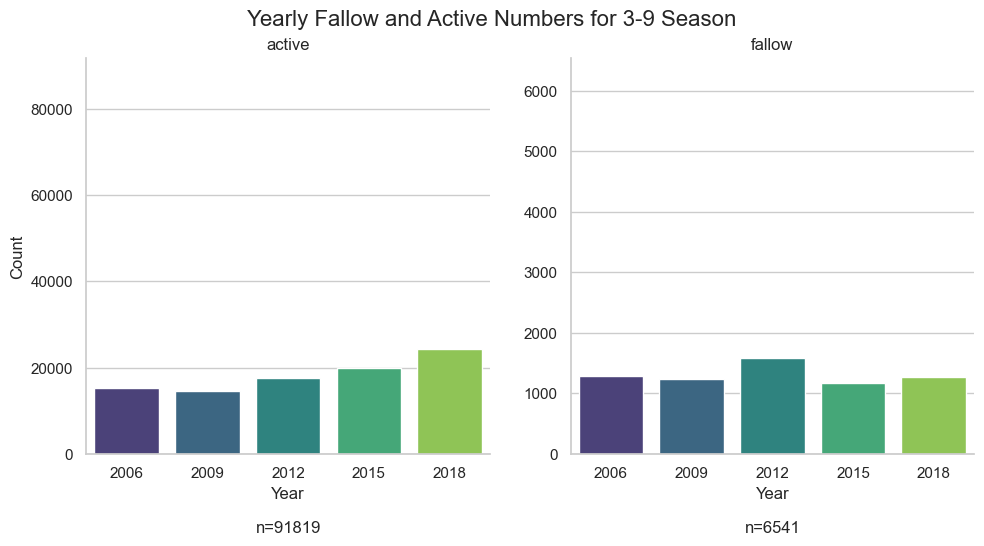

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Function to plot data for the single season
def plot_season_data(data):
    # Get the unique value from the "season" column
    season_name = data['season'].unique()[0]  # Assuming only one unique value for the season

    # Get the maximum count of observations for setting ylim
    max_count = data.groupby(['land_use_classes', 'year']).size().max()

    # Calculate the total number of rows per cover class
    total_per_class = data['land_use_classes'].value_counts()

    # Determine the number of unique land_use_classes
    num_land_use_classes = len(data['land_use_classes'].unique())

    # Calculate the number of columns based on the number of unique land_use_classes
    col_wrap = min(5, num_land_use_classes)

    # Create a facet grid with seaborn
    g = sns.FacetGrid(data, col="land_use_classes", col_wrap=col_wrap, height=5, sharey=False)

    # Map a bar plot for the number of observations per year, color by year
    g.map(sns.countplot, "year", order=sorted(data['year'].unique()), palette="viridis", legend=False)

    # Set titles and labels
    g.set_axis_labels("Year", "Count")
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(wspace=0.2)
    g.fig.suptitle(f"Yearly Fallow and Active Numbers for {season_name} Season", fontsize=16, y=1.02)  # Hier wurde die Überschrift angepasst

    # Set different ylim for the fallow subplot
    for ax, (cover_class, total_obs) in zip(g.axes.flat, total_per_class.items()):
        ax.set(ylim=(0, total_obs))
        
        # Annotate each subplot with the total number of observations per cover class
        ax.text(0.5, -0.2, f'n={total_obs}', transform=ax.transAxes, ha='center', va='baseline')

    # Show the plot
    plt.show()

# Plot für die einzelne Saison
plot_season_data(training_data)


DO NOT USE unless you want to do modeling using multiple seasons 

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Filter data for Seasons
# early_season_data= training_data[training_data['season'] == '3-5']
# mid_season_data  = training_data[training_data['season'] == '5-7']
# late_season_data = training_data[training_data['season'] == '7-9']
# full_season_data = training_data[training_data['season'] == '3-9']

# # Set the style of seaborn
# sns.set(style="whitegrid")

# # Function to plot data for each season
# def plot_season_data_multiple(data, season_name):
#     # Get the maximum count of observations for setting ylim
#     max_count = data.groupby(['land_use_classes', 'year']).size().max()

#     # Calculate the total number of rows per cover class
#     total_per_class = data['land_use_classes'].value_counts()

#     # Determine the number of unique land_use_classes
#     num_land_use_classes = len(data['land_use_classes'].unique())

#     # Calculate the number of columns based on the number of unique land_use_classes
#     col_wrap = min(5, num_land_use_classes)

#     # Create a facet grid with seaborn
#     g = sns.FacetGrid(data, col="land_use_classes", col_wrap=col_wrap, height=5, sharey=False)

#     # Map a bar plot for the number of observations per year, color by year
#     g.map(sns.countplot, "year", order=sorted(data['year'].unique()), palette="viridis", legend = False)

#     # Set titles and labels
#     g.set_axis_labels("Year", "Count")
#     g.set_titles(col_template="{col_name}")
#     plt.subplots_adjust(wspace=0.2)
#     g.fig.suptitle(f"Yearly Fallow and Active Numbers for {season_name}", fontsize=16, y=1.02)

#     # Set different ylim for the fallow subplot
#     for ax, (cover_class, total_obs) in zip(g.axes.flat, total_per_class.items()):
#         ax.set(ylim=(0, total_obs))
        
#         # Annotate each subplot with the total number of observations per cover class
#         ax.text(0.5, -0.2, f'n={total_obs}', transform=ax.transAxes, ha='center', va='baseline')

#     # Show the plot
#     plt.show()



# # Plot für Alles
# #plot_season_data_multiple(training_data, "All Seasons Combined")

# # Plot for Early Season (3-5)
# #plot_season_data_multiple(early_season_data, "Early Season")

# # Plot for Mid-Season (5-7)
# #plot_season_data_multiple(mid_season_data, "Mid-Season")

# # Plot for Late Season (7-9)
# #plot_season_data_multiple(late_season_data, "Late Season")

# # Plot for Full-Season (3-9)
# #plot_season_data_multiple(full_season_data, f"Full-Season ({max_subset_size} samples)")


#### welche Land-Covers kommen wie häufig vor bei Fallow und Active (lc1) ? 

c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without as

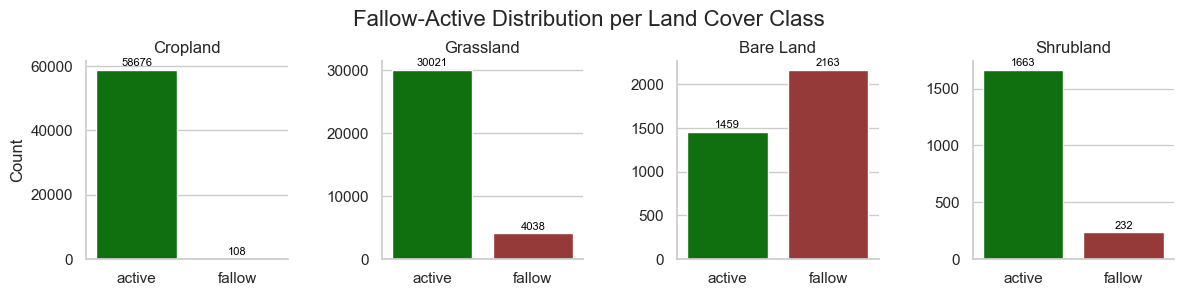

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Function to plot data for each season
def plot_landcover_occ(data):
    # Copy the data
    data_plot = data.copy()
    
    # Add a new column 'lc1_grouped' containing only the first letter of 'lc1'
    data_plot['lc1_grouped'] = data['lc1'].str[0]

    # Mapping 'lc1_grouped' to the desired legend
    legend_mapping = {'A': 'Artificial',
                      'B': 'Cropland',
                      'C': 'Woodland',
                      'D': 'Shrubland',
                      'E': 'Grassland',
                      'F': 'Bare Land',
                      'G': 'Water',
                      'H': 'Wetlands'}

    # Rename the categories in the 'lc1_grouped' column
    data_plot['lc1_grouped'] = data_plot['lc1_grouped'].map(legend_mapping)

    # Get the maximum count of observations for setting ylim
    max_count = data_plot.groupby(['lc1_grouped', 'land_use_classes']).size().max()

    # Calculate the total number of rows per cover class
    total_per_class = data_plot['lc1_grouped'].value_counts()

    # Create a facet grid with seaborn
    g = sns.FacetGrid(data_plot, col="lc1_grouped", col_wrap=4, height=3, sharey=False)

    # Map a bar plot for the number of observations per class, color by class
    g.map(sns.countplot, "land_use_classes", order=sorted(data_plot['land_use_classes'].unique()), palette={"active": "green", "fallow": "brown"}, legend=False)

    # Set titles and labels
    g.set_axis_labels('', "Count")
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(top=0.88)  # Adjust the top margin to make room for title

    # Annotate each subplot with the total number of observations per cover class
    for ax, (cover_class, total_obs) in zip(g.axes.flat, total_per_class.items()):
        #ax.text(0.5, 1.1, f'n={total_obs:.0f}', transform=ax.transAxes, ha='center', va='baseline')
        
        # Add counts on top of the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')

    # Show the plot with a dynamic title based on the content of the 'season' column
    plt.suptitle(f"Fallow-Active Distribution per Land Cover Class ", fontsize=16, y=1.05)  # Move the title up
    plt.show()

# Plot Data
plot_landcover_occ(training_data)


DO NOT USE unless you want to do modeling using multiple seasons 

In [13]:
# # Filter data for Early Season (3-5), Mid-Season (5-7), Late Season (7-9), and Full Season (3-9)
# early_season_data = training_data[training_data['season'] == '3-5']
# mid_season_data = training_data[training_data['season'] == '5-7']
# late_season_data = training_data[training_data['season'] == '7-9']
# full_season_data = training_data[training_data['season'] == '3-9']

# # Function to plot data for each season
# def plot_landcover_occ_multiple(data, season_name):
#     # Kopie der Daten erstellen
#     data_plot = data.copy()
    
#     # Eine neue Spalte 'lc1_grouped' hinzufügen, die nur den ersten Buchstaben von 'lc1' enthält
#     data_plot['lc1_grouped'] = data['lc1'].str[0]

#     # Mapping von 'lc1_grouped' auf die gewünschte Legende
#     legend_mapping = {'A': 'Artificial',
#                       'B': 'Cropland',
#                       'C': 'Woodland',
#                       'D': 'Shrubland',
#                       'E': 'Grassland',
#                       'F': 'Bare Land',
#                       'G': 'Water',
#                       'H': 'Wetlands'}

#     # Umbenennen der Kategorien in der 'lc1_grouped'-Spalte
#     data_plot['lc1_grouped'] = data_plot['lc1_grouped'].map(legend_mapping)

#     # Setzen des seaborn-Stils
#     sns.set(style="whitegrid")

#     # Maximale Anzahl der Beobachtungen für die Einstellung von ylim erhalten
#     max_count = data_plot.groupby(['lc1_grouped', 'land_use_classes']).size().max()

#     # Gesamtzahl der Zeilen pro Abdeckungsklasse berechnen
#     total_per_class = data_plot['lc1_grouped'].value_counts()

#     # Erstellen eines Facettenrasters mit seaborn
#     g = sns.FacetGrid(data_plot, col="lc1_grouped", col_wrap=4, height=3, sharey=False)

#     # Zuordnen eines Balkendiagramms für die Anzahl der Beobachtungen pro Klasse, Farbe nach Klasse
#     g.map(sns.countplot, "land_use_classes", order=sorted(data_plot['land_use_classes'].unique()), palette="viridis", legend=False)

#     # Titel und Beschriftungen setzen
#     g.set_axis_labels("Land Use Classes", "Count")
#     g.set_titles(col_template="{col_name}")
#     plt.subplots_adjust(top=0.9)

#     # Annotieren jedes Subplots mit der Gesamtanzahl der Beobachtungen pro Abdeckungsklasse
#     for ax, (cover_class, total_obs) in zip(g.axes.flat, total_per_class.items()):
#         ax.text(0.5, 1.1, f'n={total_obs}', transform=ax.transAxes, ha='center', va='baseline')

#     # Plot anzeigen
#     plt.suptitle(f"Number of Observations per Land Use Class {season_name}", fontsize=16, y=1.02)
#     plt.show()

# # Plot für Alles
# plot_landcover_occ_multiple(training_data, "All Seasons Combined")

# # Plot for Early Season (3-5)
# plot_landcover_occ_multiple(early_season_data, "Early Season")

# # Plot for Mid-Season (5-7)
# plot_landcover_occ_multiple(mid_season_data, "Mid-Season")

# # Plot for Late Season (7-9)
# plot_landcover_occ_multiple(late_season_data, "Late Season")

# # Plot for Full-Season (3-9)
# plot_landcover_occ_multiple(full_season_data, f"(Full-Season) ({max_subset_size} s_size)")


## ML Model Setup

### Setting up Caching of optimal model outputs

In [14]:
# Define the paths for saving and loading the models
save_path = workPath + "/02_Training/ML_caching"

# Construct the model paths with information about season and sample size
rf_model_path = os.path.join(save_path, f"rf_regression_model_{desired_seasons}_{max_subset_size}.pkl")
ee_model_path = os.path.join(save_path, f"ee_regressor_model_{desired_seasons}_{max_subset_size}.pkl")
#svm_model_path = os.path.join(save_path, f"svm_regression_model_{desired_seasons}_{max_subset_size}.pkl")
#ee_svm_model_path = os.path.join(save_path, f"ee_svm_regressor_model_{desired_seasons}_{max_subset_size}.pkl")

# To load the models if they exist:
if os.path.exists(rf_model_path):
    best_mod = joblib.load(rf_model_path)

if os.path.exists(ee_model_path):
    ee_regressor = joblib.load(ee_model_path)

# if os.path.exists(svm_model_path):
#    best_mod_svm = joblib.load(svm_model_path)

# if os.path.exists(ee_svm_model_path):
#    ee_svm_regressor = joblib.load(ee_svm_model_path)

### Cache cleaning

set flush_cash = True to clean cache

In [15]:
flush_cash = False

# To flush (delete) the models if needed:
if flush_cash:
    if os.path.exists(rf_model_path):
        os.remove(rf_model_path)
    if os.path.exists(ee_model_path):
        os.remove(ee_model_path)
    # if os.path.exists(svm_model_path):  
    #     os.remove(svm_model_path)
    # if os.path.exists(ee_svm_model_path):
    #     os.remove(ee_svm_model_path)

### Prep training and test data

In dieser Version des Codes werden die Daten basierend auf den ausgewählten Jahreszeiten (seasons_to_use) gefiltert, und dann werden Trainings- und Testdaten nur aus den gefilterten Daten für diese Jahreszeiten erstellt.

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Dictionary to store data for each class
class_data = {}

# Separate data based on classes
for class_label in np.unique(training_data['land_use_classes']):
    class_data[class_label] = training_data[training_data['land_use_classes'] == class_label]

# Initialize empty lists for train and test data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Percentage split for training and test data
train_percentage = 0.7  # 70% for training, adjust as needed

# Split each class into training and test sets for the selected seasons
for class_label, class_df in class_data.items():
    # Filter data for the selected seasons
    class_df_seasons = class_df[class_df['season'].isin(desired_seasons)]
    
    # Separate features and target
    X_class = class_df_seasons.drop(['DEM', 'id', 'lc1', 'lu1_label', 'point_id', 'point_id', 'year', 'land_use_classes', 'season'], axis=1)
    X_class = X_class.loc[:, ~X_class.columns.str.contains('bio')]
    y_class = class_df_seasons['land_use_classes']
    
    # Split class data into training and test sets
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
        X_class, y_class, test_size=1 - train_percentage, stratify=y_class, random_state=42
    )

    # Append the class data to the overall lists
    X_train_list.append(X_class_train)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class_train)
    y_test_list.append(y_class_test)

# Concatenate data from all classes to create final training and test sets
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Shuffle the data (optional)
shuffle_index_train = np.random.permutation(len(X_train))
shuffle_index_test = np.random.permutation(len(X_test))

X_train, y_train = X_train.iloc[shuffle_index_train], y_train.iloc[shuffle_index_train]
X_test, y_test = X_test.iloc[shuffle_index_test], y_test.iloc[shuffle_index_test]

# Check the shape of the training set
print("Shape of the training set:", X_train.shape)
# Check the shape of the test set
print("Shape of the test set:", X_test.shape)

# Label encoding for y_train and y_test
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Check the unique encoded values
encoded_classes = label_encoder.classes_
print("Encoded classes:", encoded_classes)


# Calculate the total number of samples in the training and test sets
total_samples_initial = len(training_data)
total_samples_train = len(y_train)
total_samples_test = len(y_test)

# Print class distribution in the initial training data as percent
print("Class distribution in initial training data:")
print((training_data['land_use_classes'].value_counts() / total_samples_initial) * 100)

# Print class distribution in training and test sets
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())
print((pd.Series(y_train).value_counts() / total_samples_train) * 100)

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())
print((pd.Series(y_test).value_counts() / total_samples_test) * 100)

# Calculate the total number of samples in the training and test sets
total_samples_initial = len(training_data)
total_samples_train = len(y_train)
total_samples_test = len(y_test)


Shape of the training set: (68851, 128)
Shape of the test set: (29509, 128)
Encoded classes: ['active' 'fallow']
Class distribution in initial training data:
land_use_classes
active    93.349939
fallow     6.650061
Name: count, dtype: float64
Class distribution in training set:
0    64273
1     4578
Name: count, dtype: int64
0    93.350859
1     6.649141
Name: count, dtype: float64

Class distribution in test set:
0    27546
1     1963
Name: count, dtype: int64
0    93.347792
1     6.652208
Name: count, dtype: float64


## Model Training

## Random Forest

In [17]:

# Create a classifier instance
RF = RandomForestClassifier(class_weight='balanced', random_state=42) # balanced
param_grid = {
    'max_depth':list(np.arange(10, 100, step=10)) + [None],
            'n_estimators':np.arange(10, 60, step=5),
            'max_features':randint(1,80),
            'criterion':['gini','entropy'],
            'min_samples_leaf':randint(5,80),
            'min_samples_split':np.arange(5, 80, step=2)
        }


RF_cv = RandomizedSearchCV(RF, 
                            param_distributions=param_grid, 
                            n_iter=5, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
                            n_jobs= -1, 
                            random_state=42, 
                            scoring='f1', # Wenn das Hauptziel darin besteht, das Ungleichgewicht der Klassen zu berücksichtigen, könnten Metriken wie Precision, Recall oder F1-Score relevanter sein als die Accuracy.
                            verbose=3)

# Fit the RandomizedSearchCV to your data
RF_cv.fit(X_train, y_train)

# Get the best parameters
best_params = RF_cv.best_params_

# Create the best model with the best parameters
best_mod = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)
best_mod.fit(X_train, y_train)

# Optionally, evaluate the best model on the test set
test_score = best_mod.score(X_test, y_test)

# Print the best parameters and test score
print("Best Parameters:", best_params)
print("Test Set Score:", test_score)

# Save the RandomForestrf model as a pickle
joblib.dump(best_mod, rf_model_path)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 80, 'max_features': 24, 'min_samples_leaf': 7, 'min_samples_split': 47, 'n_estimators': 30}
Test Set Score: 0.9206682706970755


["E:/MAP_git/02_Training/ML_caching\\rf_regression_model_['3-9']_100000.pkl"]

### Konvertierung in Earth-Engine Format und speicherung als Pickle

In [18]:

# from geemap import ml
# # Get the feature names
# feature_names = X_class.columns.tolist()
# # Convert the model to a string representation
# best_mod_str = ml.rf_to_strings(best_mod, feature_names, output_mode="CLASSIFICATION", processes =8)
# # Convert the string representation back to a classifier
# ee_rf = ml.strings_to_classifier(best_mod_str)

# # Save the Earth Engine RandomForestrf model as a pickle
# joblib.dump(ee_rf, ee_model_path)

# ee_rf

# file_size = os.path.getsize(ee_model_path) / (1024 * 1024)
# print(f"The file size of {ee_model_path} \n is {file_size} MB.")


## Metrics

### Performance Metriken und Konfusionsmatrixen für Training und Testdaten

Training Set Metrics:
Accuracy: 0.9726
Precision: 0.9772
Recall: 0.9726
F1 Score: 0.9741

Testing Set Metrics:
Accuracy: 0.9207
Precision: 0.9149
Recall: 0.9207
F1 Score: 0.9176


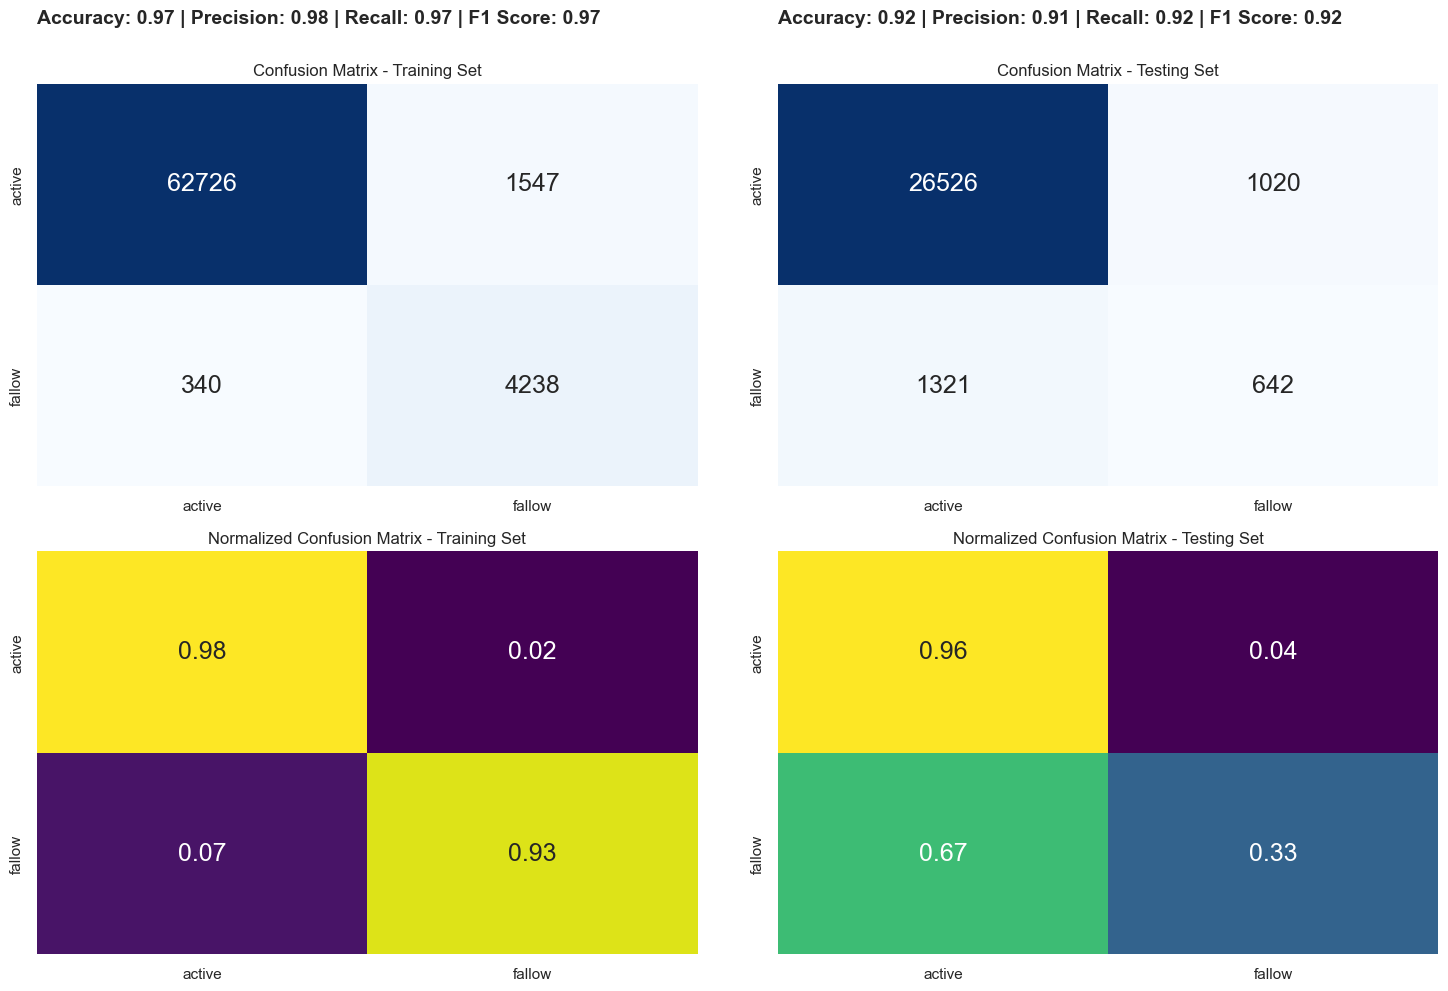

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Set the style of seaborn
sns.set(style="whitegrid")

# Load the best model
best_mod = joblib.load(rf_model_path)

# Make predictions
y_train_pred = best_mod.predict(X_train)
y_test_pred = best_mod.predict(X_test)

# Get unique class labels
class_labels = sorted(set(y_train))

# Evaluate on training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Evaluate on testing set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Print metrics
print("Training Set Metrics:")
print("Accuracy: {:.4f}".format(accuracy_train))
print("Precision: {:.4f}".format(precision_train))
print("Recall: {:.4f}".format(recall_train))
print("F1 Score: {:.4f}".format(f1_train))

print("\nTesting Set Metrics:")
print("Accuracy: {:.4f}".format(accuracy_test))
print("Precision: {:.4f}".format(precision_test))
print("Recall: {:.4f}".format(recall_test))
print("F1 Score: {:.4f}".format(f1_test))

# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=class_labels)
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=class_labels)

# Normalize the confusion matrices
conf_matrix_train_normalized = conf_matrix_train.astype('float') / conf_matrix_train.sum(axis=1)[:, np.newaxis]
conf_matrix_test_normalized = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training set confusion matrix
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 18},
            xticklabels=["active", "fallow"], yticklabels=["active", "fallow"], ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - Training Set")

# Training set normalized confusion matrix
sns.heatmap(conf_matrix_train_normalized, annot=True, fmt=".2f", cmap="viridis", cbar=False, annot_kws={"size": 18},
            xticklabels=["active", "fallow"], yticklabels=["active", "fallow"], ax=axes[1, 0])
axes[1, 0].set_title("Normalized Confusion Matrix - Training Set")

# Testing set confusion matrix
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 18},
            xticklabels=["active", "fallow"], yticklabels=["active", "fallow"], ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix - Testing Set")

# Testing set normalized confusion matrix
sns.heatmap(conf_matrix_test_normalized, annot=True, fmt=".2f", cmap="viridis", cbar=False, annot_kws={"size": 18},
            xticklabels=["active", "fallow"], yticklabels=["active", "fallow"], ax=axes[1, 1])
axes[1, 1].set_title("Normalized Confusion Matrix - Testing Set")

# Add metrics to the plots
axes[0, 0].text(0, -0.3, f"Accuracy: {accuracy_train:.2f} | Precision: {precision_train:.2f} | Recall: {recall_train:.2f} | F1 Score: {f1_train:.2f}", ha='left', fontsize=14, fontdict={'weight': 'bold'})
axes[0, 1].text(0, -0.3, f"Accuracy: {accuracy_test:.2f} | Precision: {precision_test:.2f} | Recall: {recall_test:.2f} | F1 Score: {f1_test:.2f}", ha='left', fontsize=14, fontdict={'weight': 'bold'})

# Add a title
#plt.suptitle("Exemplary Performance Metrics of the Random Forest Classifier (Full Season with n=100,000 )", fontsize=20, y=1, fontdict={'weight': 'bold'})

plt.tight_layout()
plt.show()


### Feature Importance Plot

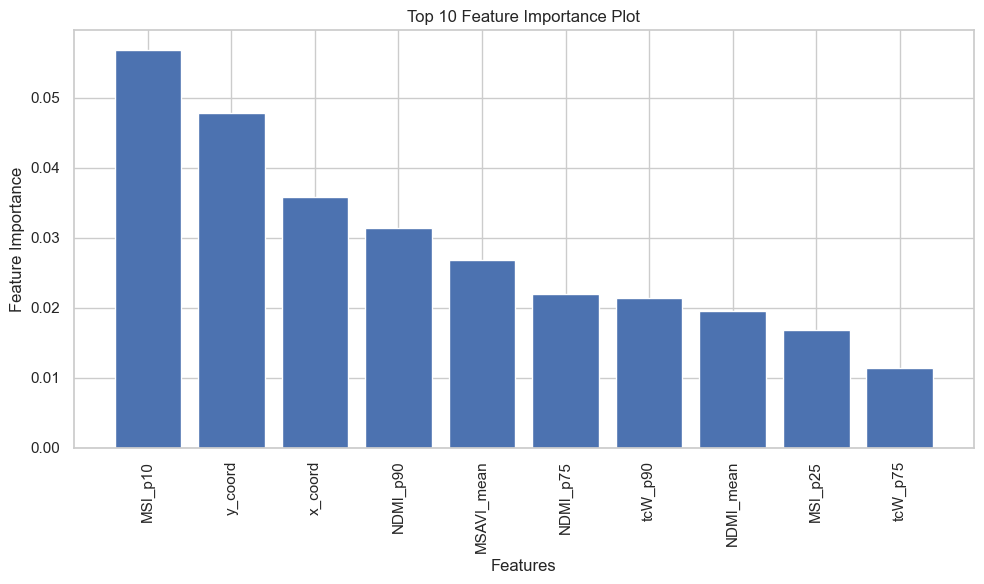

In [33]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Anzahl der Top-Merkmale, die im Plot angezeigt werden sollen
# top_n_features = 10

# # Extrahiere die Feature-Importance-Werte aus dem trainierten Random Forest-Modell
# feature_importance = best_mod.feature_importances_

# # Extrahiere die Namen der Merkmale
# feature_names = X_train.columns

# # Sortiere die Feature-Importance-Werte und die entsprechenden Merkmalsnamen absteigend nach ihrer Wichtigkeit
# sorted_idx = feature_importance.argsort()[::-1][:top_n_features]
# sorted_feature_importance = feature_importance[sorted_idx]
# sorted_feature_names = feature_names[sorted_idx]

# # Plotte die Feature-Importance-Werte
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
# plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Feature Importance')
# plt.title('Top {} Feature Importance Plot'.format(top_n_features))
# plt.tight_layout()
# plt.show()


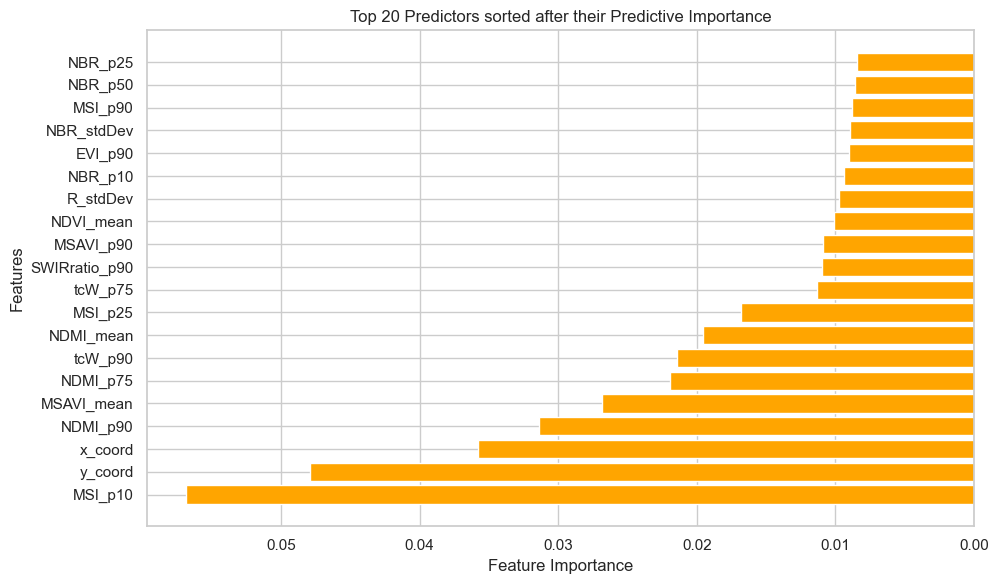

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Anzahl der Top-Merkmale, die im Plot angezeigt werden sollen
top_n_features = 20

# Extrahiere die Feature-Importance-Werte aus dem trainierten Random Forest-Modell
feature_importance = best_mod.feature_importances_

# Extrahiere die Namen der Merkmale
feature_names = X_train.columns

# Sortiere die Feature-Importance-Werte und die entsprechenden Merkmalsnamen absteigend nach ihrer Wichtigkeit
sorted_idx = feature_importance.argsort()[::-1][:top_n_features]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plotte die Feature-Importance-Werte
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center', color='orange')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Predictors sorted after their Predictive Importance'.format(top_n_features))
plt.gca().invert_yaxis()  # Invertiere die Achse, damit das wichtigste Merkmal oben ist
plt.tight_layout()
plt.gca().invert_xaxis()  # Invertiere die x-Achse, um die wichtigen Merkmale rechts zu platzieren
plt.gca().invert_yaxis()  # Invertiere die y-Achse zurück
plt.show()


### ROC Kurve

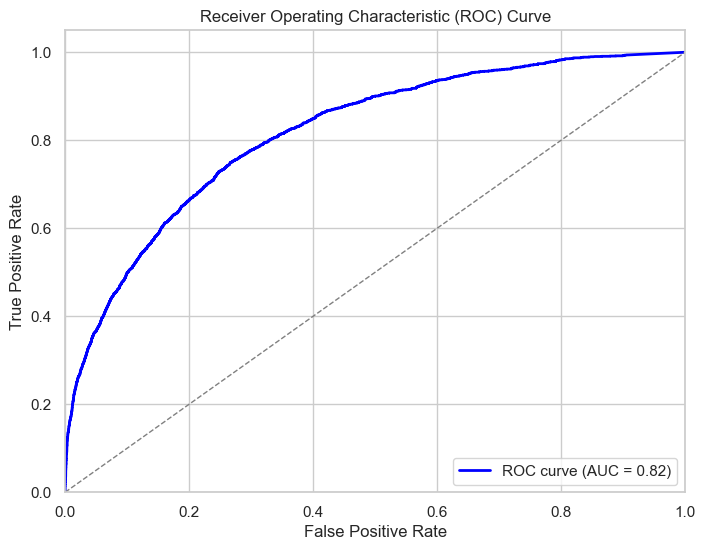

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the predicted probabilities for class 1 (fallow)
y_test_prob = best_mod.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_test_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


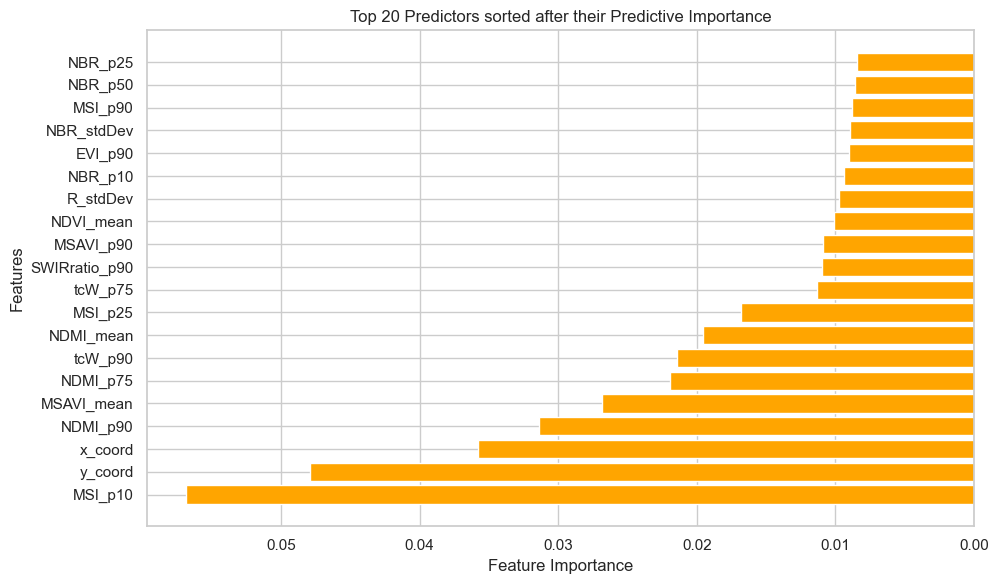

<Figure size 1000x600 with 0 Axes>

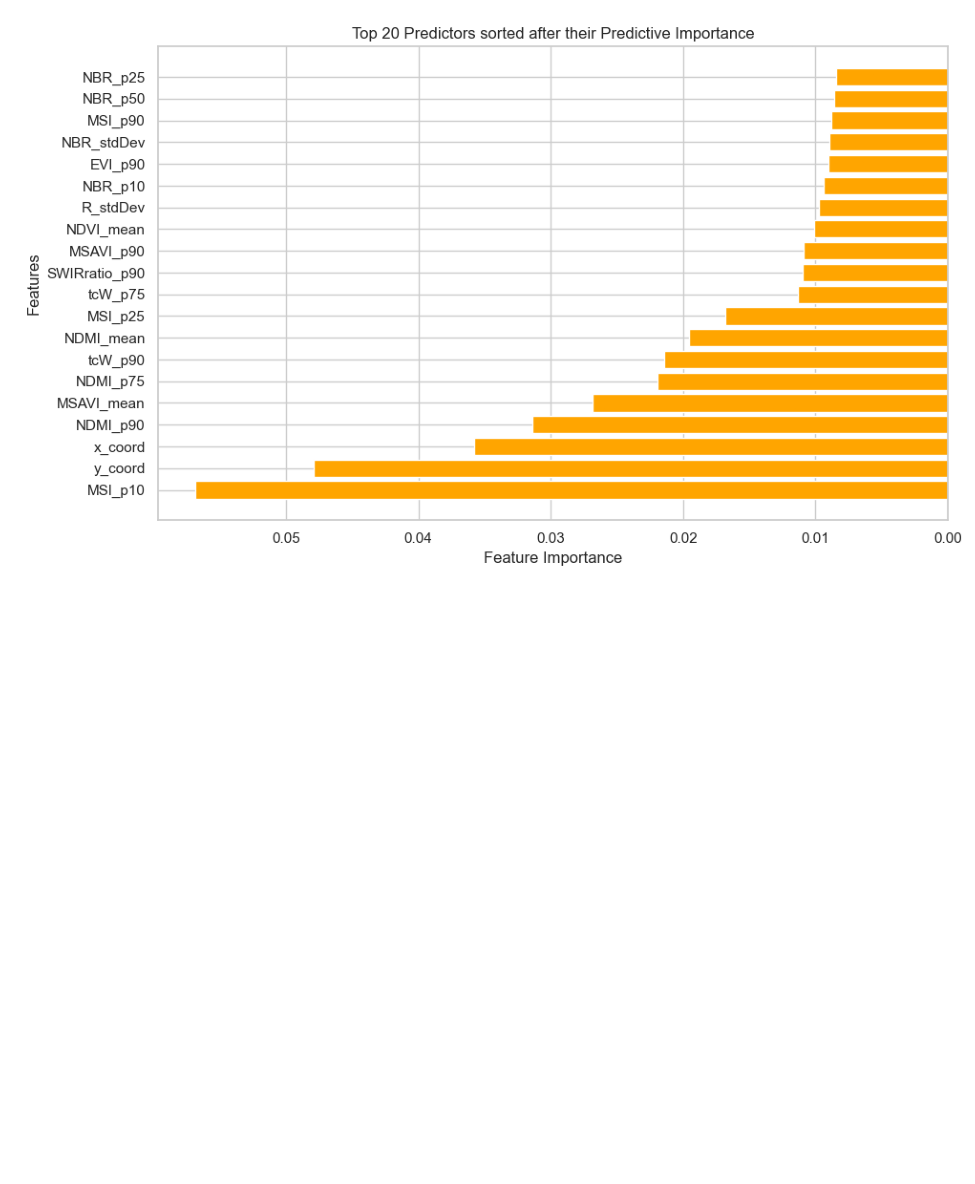

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Anzahl der Top-Merkmale, die im Plot angezeigt werden sollen
top_n_features = 20

# Extrahiere die Feature-Importance-Werte aus dem trainierten Random Forest-Modell
feature_importance = best_mod.feature_importances_

# Extrahiere die Namen der Merkmale
feature_names = X_train.columns

# Sortiere die Feature-Importance-Werte und die entsprechenden Merkmalsnamen absteigend nach ihrer Wichtigkeit
sorted_idx = feature_importance.argsort()[::-1][:top_n_features]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plotte die Feature-Importance-Werte
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center', color='orange')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Predictors sorted after their Predictive Importance'.format(top_n_features))
plt.gca().invert_yaxis()  # Invertiere die Achse, damit das wichtigste Merkmal oben ist
plt.tight_layout()
plt.gca().invert_xaxis()  # Invertiere die x-Achse, um die wichtigen Merkmale rechts zu platzieren
plt.gca().invert_yaxis()  # Invertiere die y-Achse zurück

# Speichere den ersten Plot
plt.savefig('feature_importance_plot.png')

# Plotte die Confusion Matrices
plt.figure(figsize=(10, 6))

# (Hier kommt dein Code für die Confusion Matrices hin)

# Speichere den zweiten Plot
plt.savefig('confusion_matrices_plot.png')

# Plotte beide Plots untereinander
plt.figure(figsize=(10, 12))

# Lade und plotte den ersten Plot
plt.subplot(2, 1, 1)
plt.imshow(plt.imread('feature_importance_plot.png'))
plt.axis('off')

# Lade und plotte den zweiten Plot
plt.subplot(2, 1, 2)
plt.imshow(plt.imread('confusion_matrices_plot.png'))
plt.axis('off')

plt.tight_layout()
plt.show()


## Spatialize Prediction in GEE

WIP

nothing works yet

In [20]:
# envelope, projSite = ProjSite_ToeeGeom(workPath + "/00_Shapefiles/wildE/europe_aggregated.gpkg")

# LND_stm = Seasonal_STMs_C2(2021, projSite, 1, 12, reducer="all")

# # Manuell die Bänder auswählen, die behalten werden sollen
# bands_to_keep = ['B_mean', 'B_stdDev', 'B_p10', 'B_p25', 'B_p50', 'B_p75', 'B_p90', 'G_mean', 'G_stdDev', 'G_p10', 'G_p25', 'G_p50', 'G_p75', 'G_p90', 'R_mean', 'R_stdDev', 'R_p10', 'R_p25', 'R_p50', 'R_p75', 'R_p90', 'NIR_mean', 'NIR_stdDev', 'NIR_p10', 'NIR_p25', 'NIR_p50', 'NIR_p75', 'NIR_p90', 'SWIR1_mean', 'SWIR1_stdDev', 'SWIR1_p10', 'SWIR1_p25', 'SWIR1_p50', 'SWIR1_p75', 'SWIR1_p90', 'SWIR2_mean', 'SWIR2_stdDev', 'SWIR2_p10', 'SWIR2_p25', 'SWIR2_p50', 'SWIR2_p75', 'SWIR2_p90', 'NDVI_mean', 'NDVI_stdDev', 'NDVI_p10', 'NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_p90', 'SWIRratio_mean', 'SWIRratio_stdDev', 'SWIRratio_p10', 'SWIRratio_p25', 'SWIRratio_p50', 'SWIRratio_p75', 'SWIRratio_p90', 'NDWI_mean', 'NDWI_stdDev', 'NDWI_p10', 'NDWI_p25', 'NDWI_p50', 'NDWI_p75', 'NDWI_p90', 'EVI_mean', 'EVI_stdDev', 'EVI_p10', 'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_p90', 'MSAVI_mean', 'MSAVI_stdDev', 'MSAVI_p10', 'MSAVI_p25', 'MSAVI_p50', 'MSAVI_p75', 'MSAVI_p90', 'tcB_mean', 'tcB_stdDev', 'tcB_p10', 'tcB_p25', 'tcB_p50', 'tcB_p75', 'tcB_p90', 'tcG_mean', 'tcG_stdDev', 'tcG_p10', 'tcG_p25', 'tcG_p50', 'tcG_p75', 'tcG_p90', 'tcW_mean', 'tcW_stdDev', 'tcW_p10', 'tcW_p25', 'tcW_p50', 'tcW_p75', 'tcW_p90']

# # Die ausgewählten Bänder aus dem Regressor auswählen
# ee_regressor_modified = ee_regressor.select(bands_to_keep)

# # Das Modell mit den geänderten Eingabedaten verwenden
# rf_regression = LND_stm.classify(ee_regressor_modified)
# rf_regression


# rf_regression = LND_stm.classify(ee_regressor)
# rf_regression

# esaWC21 = ee.ImageCollection("ESA/WorldCover/v200").select(['Map']).toBands().clip(projSite)

# # Define a color palette for ESA World Cover classes
# esa_palette = [
#     '#006400',  # Tree cover
#     '#ffbb22',  # Shrubland
#     '#ffff4c',  # Grassland
#     '#f096ff',  # Cropland
#     '#fa0000',  # Built-up
#     '#b4b4b4',  # Bare / sparse vegetation
#     '#f0f0f0',  # Snow and ice
#     '#0064c8',  # Permanent water bodies
#     '#0096a0',  # Herbaceous wetland
#     '#00cf75',  # Mangroves
#     '#fae6a0'   # Moss and lichen
# ]


# esa_palette = [
#     'darkgreen',  # Tree cover
#     'green',  # Shrubland
#     'lightgreen',  # Grassland
#     'lightgreen',  # Cropland
#     'red',  # Built-up
#     'red',  # Bare / sparse vegetation
#     'blue',  # Snow and ice
#     'blue',  # Permanent water bodies
#     'lightgreen',  # Herbaceous wetland
#     'lightgreen',  # Mangroves
#     'lightgreen'   # Moss and lichen
# ]

# # Define visualization parameters for ESA World Cover
# esa_vis_params = {
#     'min': 10,
#     'max': 100,
#     'palette': esa_palette
# }

In [21]:
# import folium

# # Define a method for displaying Earth Engine image tiles to folium map.
# def add_ee_layer(self, ee_image_object, vis_params, name, opacity=100):
#     map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
#     folium.raster_layers.TileLayer(
#         tiles=map_id_dict['tile_fetcher'].url_format,
#         attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
#         name=name,
#         overlay=True,
#         control=True,
#         opacity=opacity  # Set the opacity here
#     ).add_to(self)

# # Add EE drawing method to folium.
# folium.Map.add_ee_layer = add_ee_layer

# # Set the center coordinates
# center_coords = projSite.centroid().coordinates().getInfo()[::-1]

# # Create a Folium map
# map = folium.Map(location=center_coords, zoom_start=10)

# # Add the satellite basemap
# folium.TileLayer('https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google', name='Google Satellite', overlay=True).add_to(map)

# # Define visualization parameters
# vis_params = {
#     'min': 0,
#     'max': 1,
#     'palette': ["#EDF8E9", "#C7E9C0", "#A1D99B", "#74C476", "#41AB5D", "#238B45", "#005A32"]
# }

# # Set the opacity for the Earth Engine image layer (e.g., 0.7 for 70% opacity)
# opacity = 0.7


# # Add the ESA World Cover image to the map
# map.add_ee_layer(esaWC21, esa_vis_params, name='ESA World Cover')
# # Add the Earth Engine image to the map using folium_gee
# map.add_ee_layer(rf_regression, vis_params, name=f'classification_{year}', opacity=100)
# map.add_ee_layer(LND_stm.select(["NDVI_mean"]), {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, name='NDVI_mean')


# # Add a layer control to the map
# folium.LayerControl().add_to(map)


# # Display the map
# map